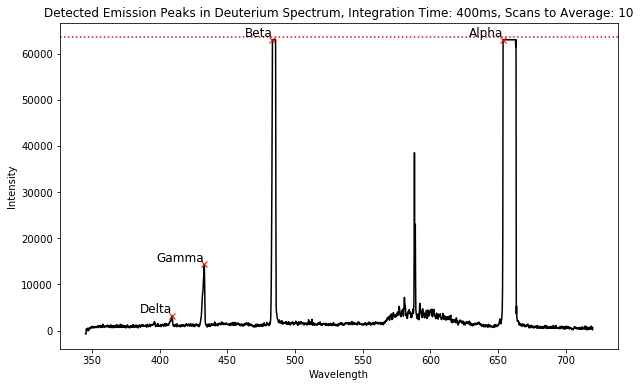

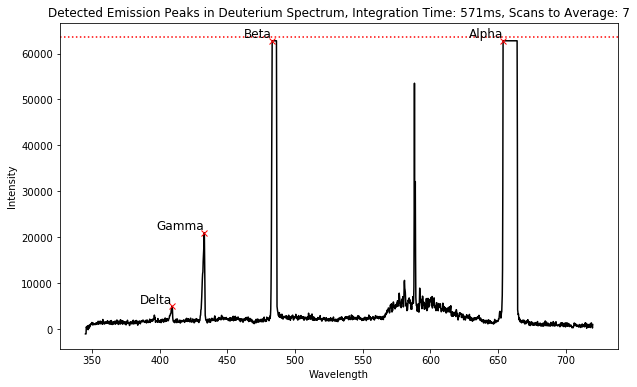

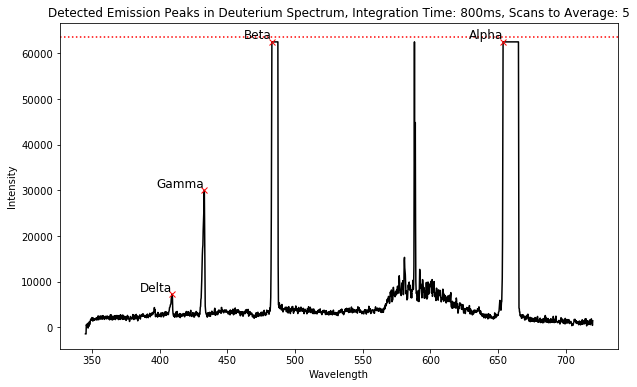

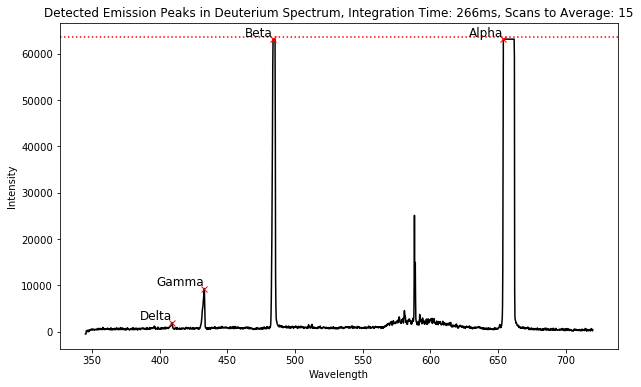

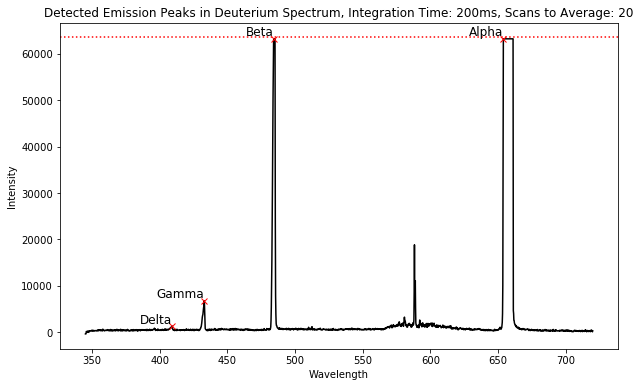

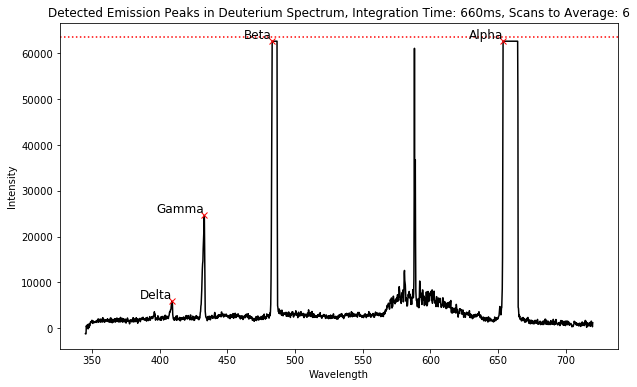

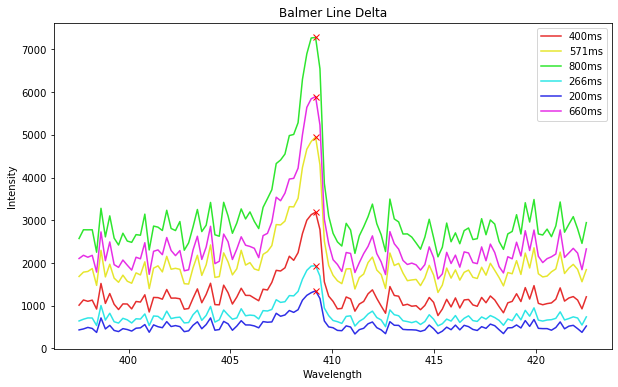

In [31]:
from pathlib import Path
import pandas as pd
from scipy.signal import find_peaks, peak_widths
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import colorsys

# Dict of balmer lines and expected wavelengths
balmer_lines = {"Delta": 410, "Gamma": 434, "Beta": 486, "Alpha": 656}

def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

class Trial:
    def __init__(self, file, saturation_line=None):
        self.file = file
        self.saturation_line = saturation_line
        self.integration_time, self.scans_to_average = self.parse_filename()
        self.data = self.read_data()
        self.peak_names, self.peak_indices, self.peak_wavelengths, self.peak_intensities = self.find_peaks()
        
    def parse_filename(self):
        parts = self.file.stem.split('_')
        assert len(parts) == 8, "Found {} parts in the filename, should be 8".format(len(parts))
        return (parts[1], parts[2])
        
    def read_data(self, skiprows=14):
        data = pd.read_csv(self.file.resolve(), skiprows=skiprows)
        data.columns = ['Wavelength', 'Intensity']
        return data

    def balmer_line_window(self, line, range_size):
        half_range_size = range_size / 2
        balmer_wavelength = balmer_lines[line]
        window_start = balmer_wavelength - half_range_size
        window_end = balmer_wavelength + half_range_size
        data_window = self.data.loc[(self.data['Wavelength'] >= window_start) & (self.data['Wavelength'] <= window_end)]
        return data_window

    def find_peaks(self):
        names = []
        indices = []
        wavelengths = []
        intensities = []
        for name, _ in balmer_lines.items():
            data_window = self.balmer_line_window(line=name, range_size=10)

            if data_window.empty:
                continue

            # Find the index with the max intensity, this is a peak
            peak_index = int(data_window['Intensity'].idxmax())
            peak_wavelength = data_window['Wavelength'][peak_index]
            peak_intensity = data_window['Intensity'][peak_index]
            assert peak_intensity == data_window['Intensity'].max(), "Indexmax should yield the max"
            names.append(name)
            indices.append(peak_index)
            wavelengths.append(peak_wavelength)
            intensities.append(peak_intensity)

        return (names, indices, wavelengths, intensities)

    def graph_raw(self):
        data_graph = self.data.loc[(self.data['Wavelength'] >= 0) & (self.data['Wavelength'] <= 720)]
        plt.figure(figsize=(10, 6))
        plt.title("Detected Emission Peaks in Deuterium Spectrum, Integration Time: {}, Scans to Average: {}".format(self.integration_time, self.scans_to_average))
        plt.plot(data_graph['Wavelength'], data_graph['Intensity'], label="Intensity vs. Wavelength", color="k")
        plt.axhline(y=self.saturation_line, color='red', linestyle=':', linewidth=1.5)
        plt.xlabel('Wavelength')
        plt.ylabel('Intensity')
        plt.plot(self.peak_wavelengths, self.peak_intensities, "x", label="Peaks", color="r")
        for name, x, y in zip(self.peak_names, self.peak_wavelengths, self.peak_intensities):
            plt.text(x, y, name, fontsize=12, ha='right', va='bottom')
        plt.show()
        
class Experiment:
    def __init__(self, folder, saturation_line=None):
        self.trials = []
        self.saturation_line = saturation_line
        for file in folder.iterdir():
            if file.is_file():
                trial = Trial(file, saturation_line)
                self.trials.append(trial)
        self.colors = self.get_colors()
                
    def graph_all_raw(self):
        for t in self.trials:
            t.graph_raw()
            
    def get_colors(self):
        num_colors = len(self.trials)
        return [colorsys.hsv_to_rgb(i / num_colors, 0.8, 0.9) for i in range(num_colors)]
            
    def graph_balmer_line_combined(self, balmer_line, range_size):
        plt.figure(figsize=(10, 6))
        plt.title("Balmer Line {}".format(balmer_line))
        for t, color in zip(self.trials, self.colors):
            balmer_range = t.balmer_line_window(balmer_line, range_size)
            plt.plot(balmer_range['Wavelength'], balmer_range['Intensity'], label=t.integration_time, color=color)
            plt.xlabel('Wavelength')
            plt.ylabel('Intensity')
            try:
                peak_index = t.peak_names.index(balmer_line)
                plt.plot(t.peak_wavelengths[peak_index], t.peak_intensities[peak_index], "x", color="r")
            except ValueError:
                print("No peak found for {}".format(balmer_line))
        plt.legend()
        plt.show()

# Example file name: deutdg_200ms_20_SR4014911__0__16-45-59-520.csv,
# where 200 is integration time, 20 is scans to average
folder = Path("/home/crystal/research/deuterium_analysis/7_13_data/deutdg")
experiment = Experiment(folder=folder, saturation_line=63500)
experiment.graph_all_raw()
experiment.graph_balmer_line_combined("Delta", 25)
